## Tests & examples with pyvkfft (OpenCL backend)

In [1]:
# Use the following to install pyvkfft on google colab
if False:
    # Install pyvkfft & dependencies only once using pip
    import os
    if not os.path.exists('dev/pyvkfft'):
      !mkdir dev
      !cd dev && git clone --recursive https://github.com/vincefn/pyvkfft.git
      !pip install pycuda
      # !pip install cupy
      !cd dev/pyvkfft && pip install .
      # scipy, matplotlib not required for pyvkfft, but for tests
      !pip install scipy matplotlib

In [2]:
import pyopencl as cl
import pyopencl.array as cla
import pyvkfft.opencl
from pyvkfft.fft import fftn as vkfftn, ifftn as vkifftn, rfftn as vkrfftn, irfftn as vkirfftn
from pyvkfft.opencl import VkFFTApp
from pyvkfft.accuracy import l2, li
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
try:
    from scipy.datasets import ascent
except:
    from scipy.misc import ascent
import numpy as np
from scipy.fft import fftn, ifftn, fftshift, rfftn, irfftn, dctn, idctn
import timeit
import os

# os.environ['PYOPENCL_CTX']=':1'

# Create some context on the first available GPU
if 'PYOPENCL_CTX' in os.environ:
    ctx = cl.create_some_context()
else:
    ctx = None
    # Find the first OpenCL GPU available and use it, unless
    for p in cl.get_platforms():
        for d in p.get_devices():
            if d.type & cl.device_type.GPU == 0:
                continue
            print("Selected device: ", d.name)
            ctx = cl.Context(devices=(d,))
            break
        if ctx is not None:
            break
cq = cl.CommandQueue(ctx)



def speed(shape, ndim, queue, nb=10, inplace=True, norm=0):
    """
    Perform a speed test using VkFFT (
    :param shape: array shape to use
    :param ndim: number of dimensions for the FFT (e.g. can be 1, 2 or 3 for a 3D array, etc..)
    :param nb: number of repeats for timing
    :param stream: the pycuda.driver.Stream to be sued for calculations. If None,
        the default stream for the active context will be used.
    :param inplace: if True (default), do an in-place FFT
    :param norm: norm=0 will have the L2 norm multiplied by the FT size for each transform,
        whereas norm=1 will divide the L2 norm by the FT size for a backwards transform,
        similarly to numpy's fft norm='backwards'.
    :return: a tuple with the time per couple of FFT and iFFT, and the idealised memory throughput
        assuming one read and one write of the array per transform axis, in Gbytes/s.
    """
    d = cla.to_device(queue, np.random.uniform(0, 1, shape).astype(np.complex64))
    if not inplace:
        d1 = cla.empty_like(d)
    # print(d.shape)
    app = VkFFTApp(d.shape, d.dtype, queue=queue, ndim=ndim, inplace=inplace, norm=norm)
    queue.finish()
    t0 = timeit.default_timer()
    for i in range(nb):
        if inplace:
            d = app.ifft(d)
            d = app.fft(d)
        else:
            d1 = app.ifft(d, d1)
            d = app.fft(d1, d)
    queue.finish()
    dt = timeit.default_timer() - t0
    shape = list(shape)
    if len(shape) < 3:
        shape += [1] * (3 - len(shape))
    gbps = d.nbytes * nb * ndim * 2 * 2 / dt / 1024 ** 3
    s = ""
    if not inplace:
        s= "[out-of-place]"
    print("(%4d %4d %4d)[%dD] dt=%6.2f ms %7.2f Gbytes/s %s [norm=%d]" %
          (shape[2], shape[1], shape[0], ndim, dt / nb * 1000, gbps, s, norm))
    return dt, gbps


#speed((16, 512, 512), 2, cq, inplace=True)
#speed((256, 256, 256), 3, cq, inplace=True)
speed((16, 768, 800), 2, cq, inplace=True)


Selected device:  NVIDIA A40
( 800  768   16)[2D] dt=  1.28 ms  459.21 Gbytes/s  [norm=0]


(0.012759644538164139, 459.21146019974066)

## Speed tests

In [3]:
if False:
    for inplace in [True, False]:
        speed((256,  256,  256), 3, cq, inplace=inplace)
        speed((400,  400,  400), 3, cq, inplace=inplace)
        speed((512,  512,  512), 3, cq, inplace=inplace)
        speed(( 16,  504,  504), 2, cq, inplace=inplace)
        speed(( 16,  512,  512), 2, cq, inplace=inplace)
        speed(( 16, 1024, 1024), 2, cq, inplace=inplace)
        speed(( 16, 2048, 2048), 2, cq, inplace=inplace)
        speed((  1,  512,  512), 2, cq, inplace=inplace)
        speed((  1, 1024, 1024), 2, cq, inplace=inplace)
        speed((  1, 2600, 2048), 2, cq, inplace=inplace)
        speed((  1, 2048, 2600), 2, cq, inplace=inplace)
        speed((  8, 2600, 2048), 2, cq, inplace=inplace)
        speed((  8, 2048, 2600), 2, cq, inplace=inplace)
        speed(( 16, 2200, 2400), 2, cq, inplace=inplace)
        speed(( 16, 2310, 2730), 2, cq, inplace=inplace)
        speed(( 16, 2730, 2310), 2, cq, inplace=inplace)  # 2310=2*3*5*7*11, 2730=2*3*5*7*13
        speed(( 16, 2400, 2200), 2, cq, inplace=inplace)
        speed((  1, 3080, 3080), 2, cq, inplace=inplace)
        speed((  8, 3072, 3072), 2, cq, inplace=inplace)


## Complex<->Complex, inplace

2629743400.0
689371240000000.0

2629743000.0
2629743734.0
689371541405696.1
2629743734.0


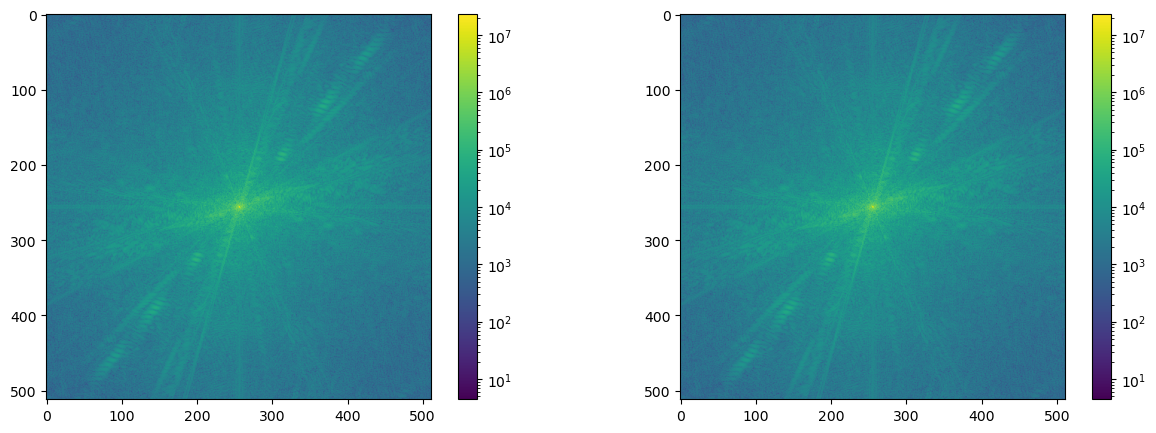

In [4]:
# single precision
d = cla.to_device(cq, ascent().astype(np.complex64))
app = VkFFTApp(d.shape, d.dtype, queue=cq, ndim=2)

print((abs(d.get()) ** 2).sum())
d = app.fft(d)
print((abs(d.get()) ** 2).sum())

print()

d = app.ifft(d)
print((abs(d.get()) ** 2).sum())

# Double precision
d = cla.to_device(cq, ascent().astype(np.complex128))
app = VkFFTApp(d.shape, d.dtype, queue=cq, ndim=2)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(np.fft.fftshift(abs(np.fft.fftn(ascent().astype(np.complex128)))), norm=LogNorm())
plt.colorbar()

print((abs(d.get()) ** 2).sum())
d = app.fft(d)

plt.subplot(122)
plt.imshow(np.fft.fftshift(abs(d.get())), norm=LogNorm())
plt.colorbar()

print((abs(d.get()) ** 2).sum())
d = app.ifft(d)
print((abs(d.get()) ** 2).sum())


## Complex<->Complex, inplace, y-axis transform
Use `axes=(-2,)` to perform a transform along specific axes, skipping the first dimension

2629743400.0
1346428200000.0

2629743400.0
2629743734.0
1346428791808.0
2629743734.0


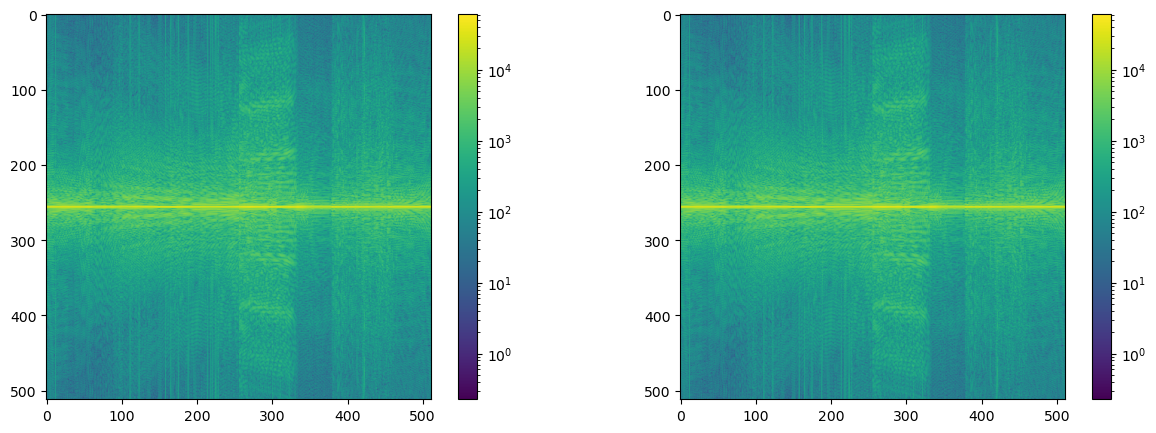

In [5]:
# single precision
axes = (-2,)
d = cla.to_device(cq, ascent().astype(np.complex64))
app = VkFFTApp(d.shape, d.dtype, queue=cq, axes=axes)

print((abs(d.get()) ** 2).sum())
d = app.fft(d)
print((abs(d.get()) ** 2).sum())

print()

d = app.ifft(d)
print((abs(d.get()) ** 2).sum())

# Double precision
d = cla.to_device(cq, ascent().astype(np.complex128))
app = VkFFTApp(d.shape, d.dtype, queue=cq, axes=axes)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(np.fft.fftshift(abs(np.fft.fftn(ascent().astype(np.complex128), axes=axes))), norm=LogNorm())
plt.colorbar()

print((abs(d.get()) ** 2).sum())
d = app.fft(d)

plt.subplot(122)
plt.imshow(np.fft.fftshift(abs(d.get())), norm=LogNorm())
plt.colorbar()

print((abs(d.get()) ** 2).sum())
d = app.ifft(d)
print((abs(d.get()) ** 2).sum())


## complex<->complex, out-of-place

2629743400.0
689371240000000.0
True
4.4586124 22932324.0
2629743000.0
True
2629743734.0
689371541405696.1
True
2629743734.0


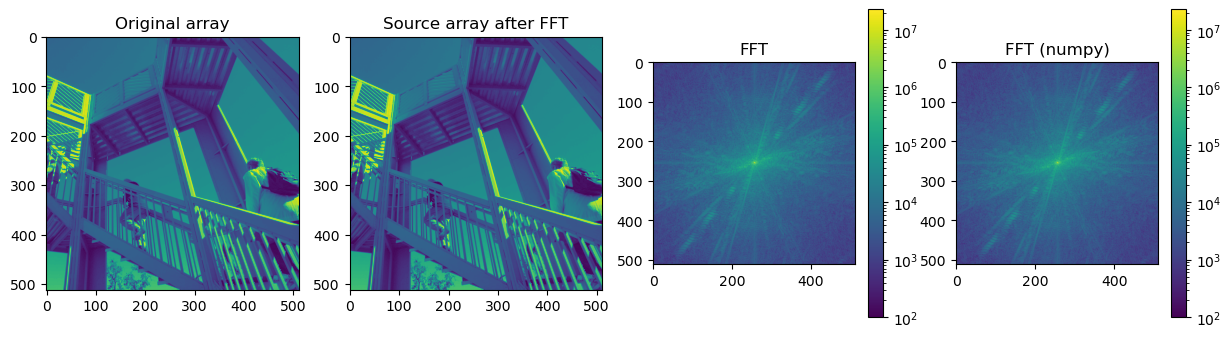

In [6]:
# single precision, out-of-place
d = cla.to_device(cq, ascent().astype(np.complex64))
d1 = cla.empty_like(d)
app = VkFFTApp(d.shape, d.dtype, queue=cq, inplace=False, ndim=2)

print((abs(d.get()) ** 2).sum())
plt.figure(figsize=(15, 4), dpi=100)
plt.subplot(141)
plt.imshow(ascent())
plt.title('Original array')

app.fft(d, d1)
cq.finish()
print((abs(d1.get()) ** 2).sum())
dn = fftn(ascent().astype(np.complex64))
print(np.allclose(dn, d1.get(), rtol=1e-6,atol=abs(dn).max()*1e-6))

plt.subplot(142)
plt.imshow(abs(d.get()))
plt.title('Source array after FFT')

plt.subplot(143)
tmp = abs(d1.get())
print(tmp.min(), tmp.max())
plt.imshow(fftshift(abs(d1.get())), norm=LogNorm(vmin=100))
plt.colorbar()
plt.title('FFT')

plt.subplot(144)
plt.imshow(fftshift(abs(fftn(ascent().astype(np.complex64)))), norm=LogNorm(vmin=100))
plt.colorbar()
plt.title('FFT (numpy)')


d = app.ifft(d1, d)
print((abs(d.get()) ** 2).sum())
print(np.allclose(ascent(), d.get(), rtol=1e-6,atol=ascent().max()*1e-6))

# double precision, out-of-place
d = cla.to_device(cq, ascent().astype(np.complex128))
d1 = cla.empty_like(d)
app = VkFFTApp(d.shape, d.dtype, queue=cq, inplace=False, ndim=2)

print((abs(d.get()) ** 2).sum())

d1 = app.fft(d, d1)
print((abs(d1.get()) ** 2).sum())
dn = fftn(ascent().astype(np.complex128))
print(np.allclose(dn, d1.get(), rtol=1e-12,atol=abs(dn).max()*1e-12))

d = app.ifft(d1, d)
print((abs(d.get()) ** 2).sum())


## Real<->Complex (half-Hermitian) inplace transform

2629743600.0
(512, 514) float32
(512, 257) complex64
610018400000000.0
(512, 257)
True
(512, 514) float32
2636300000.0
True


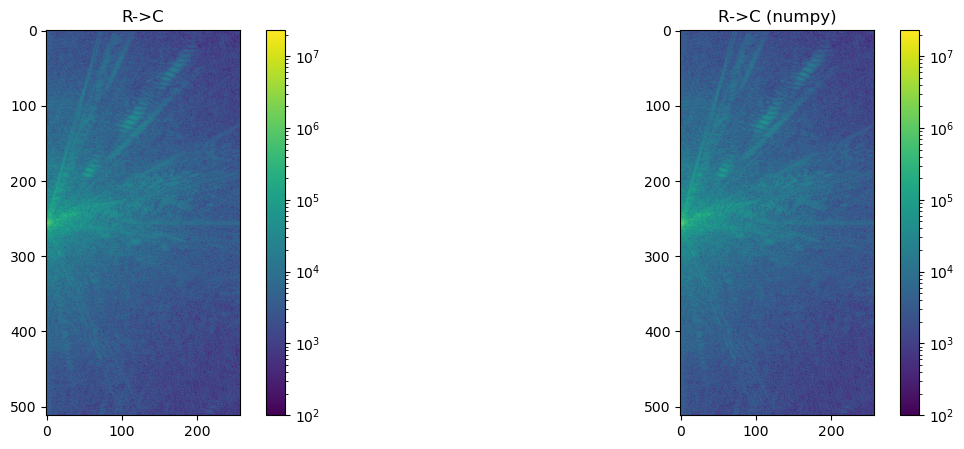

In [7]:
# single precision, R2C inplace
d0 = np.zeros((512, 514), dtype=np.float32)
d0[:, :512] = ascent()

d = cla.to_device(cq, d0)
app = VkFFTApp(d.shape, d.dtype, queue=cq, ndim=2, r2c=True)

print((abs(d.get()) ** 2).sum())
print(d.shape, d.dtype)
d = app.fft(d)
print(d.shape, d.dtype)
print((abs(d.get()) ** 2).sum())

dn = np.fft.rfftn(d0[:, :-2].astype(np.float32))
print(dn.shape)
print(np.allclose(d.get(), dn, rtol=1e-6, atol=dn.max() * 1e-6))

plt.figure(figsize=(15,5), dpi=100)
plt.subplot(121)
plt.imshow(fftshift(abs(d.get()), axes=0), norm=LogNorm(vmin=100))
plt.colorbar()
plt.title("R->C")
plt.subplot(122)
plt.imshow(fftshift(abs(dn), axes=0), norm=LogNorm(vmin=100))
plt.colorbar()
plt.title("R->C (numpy)")

d = app.ifft(d)
print(d.shape, d.dtype)
print((abs(d.get()) ** 2).sum())

print(np.allclose(d.get()[:, :-2], d0[:, :-2], rtol=1e-6, atol = 255e-6))


## Real<->Complex (half-Hermitian) out-of-place transform

2629743400.0
(512, 512) float32
(512, 257) complex64
610018400000000.0
(512, 257)
True
(512, 512) float32
2629743000.0
True


Text(0.5, 1.0, 'Original array')

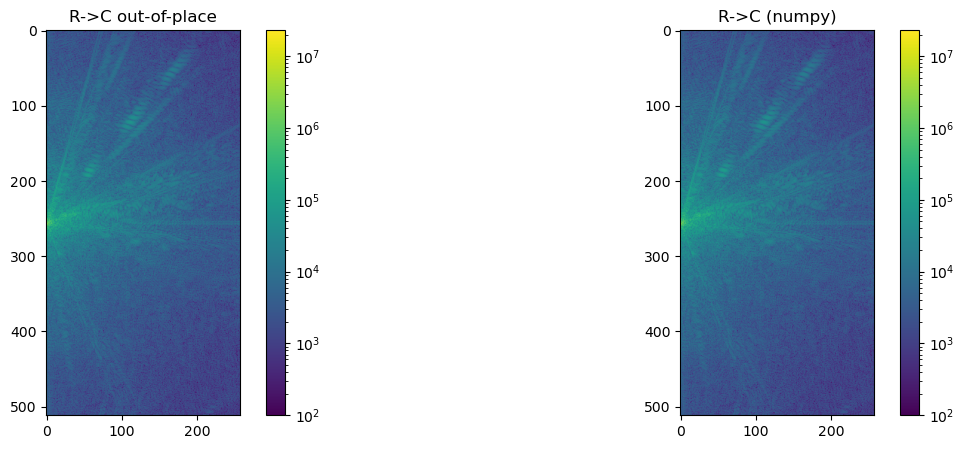

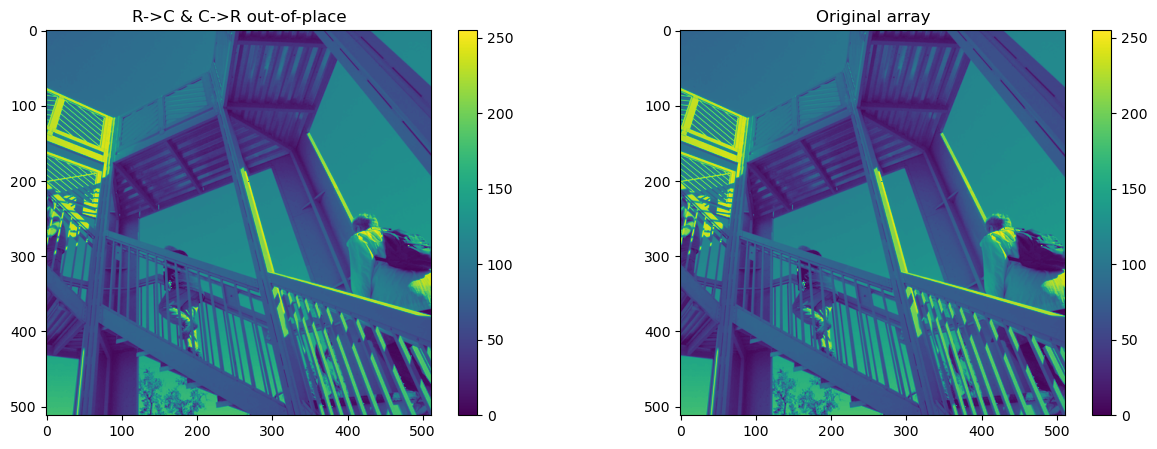

In [8]:
# single precision, R2C inplace
d0 = cla.to_device(cq, ascent().astype(np.float32))
d1 = cla.empty(cq, (512, 257), dtype=np.complex64)

app = VkFFTApp(d0.shape, d0.dtype, queue=cq, ndim=2, r2c=True, inplace=False)

print((abs(d0.get()) ** 2).sum())
print(d0.shape, d0.dtype)
d1 = app.fft(d0, d1)
print(d1.shape, d1.dtype)
print((abs(d1.get()) ** 2).sum())

dn = np.fft.rfftn(ascent().astype(np.float32))
print(dn.shape)
print(np.allclose(d1.get(), dn, rtol=1e-6, atol=dn.max() * 1e-6))

plt.figure(figsize=(15,5), dpi=100)
plt.subplot(121)
plt.imshow(fftshift(abs(d1.get()), axes=0), norm=LogNorm(vmin=100))
plt.colorbar()
plt.title("R->C out-of-place")
plt.subplot(122)
plt.imshow(fftshift(abs(dn), axes=0), norm=LogNorm(vmin=100))
plt.colorbar()
plt.title("R->C (numpy)")

d0 = app.ifft(d1, d0)
print(d0.shape, d0.dtype)
print((abs(d0.get()) ** 2).sum())

print(np.allclose(d0.get(), ascent(), rtol=1e-6, atol = 255e-6))

plt.figure(figsize=(15,5), dpi=100)
plt.subplot(121)
plt.imshow(d0.get())
plt.colorbar()
plt.title("R->C & C->R out-of-place")
plt.subplot(122)
plt.imshow(ascent())
plt.colorbar()
plt.title("Original array")


## Real<->Real transform = Direct Cosine Transform (DCT)

Testing DCT type 1
2629743400.0
9056434000000000.0
True
2629743000.0 2629743000.0
True True

Testing DCT type 2
2629743400.0
9135847000000000.0
True
2629743000.0 2629743400.0
True True

Testing DCT type 3
2629743400.0
2751634700000000.0
True
2629741600.0 2629743400.0
True True

Testing DCT type 4
2629743400.0
2757484400000000.0
True
2629741300.0 2629743000.0
True True



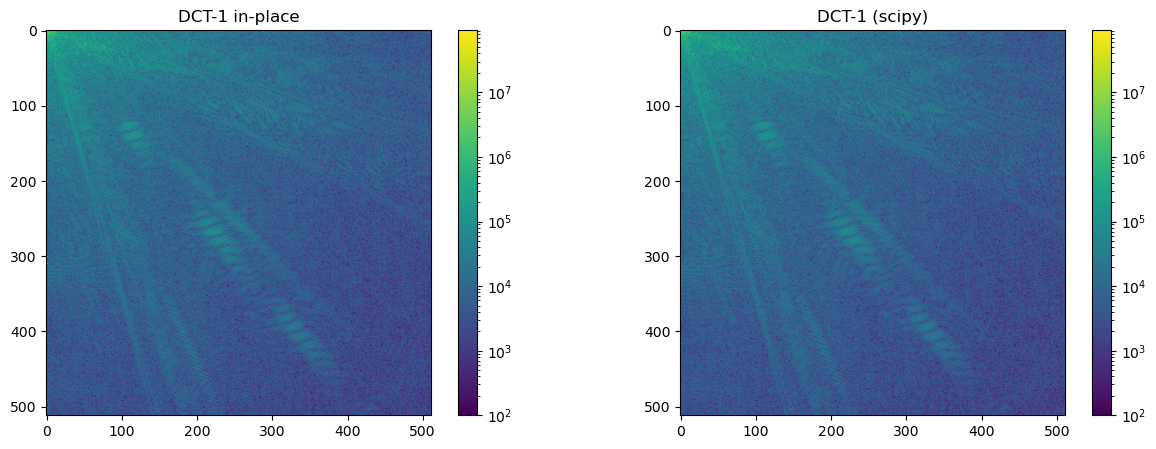

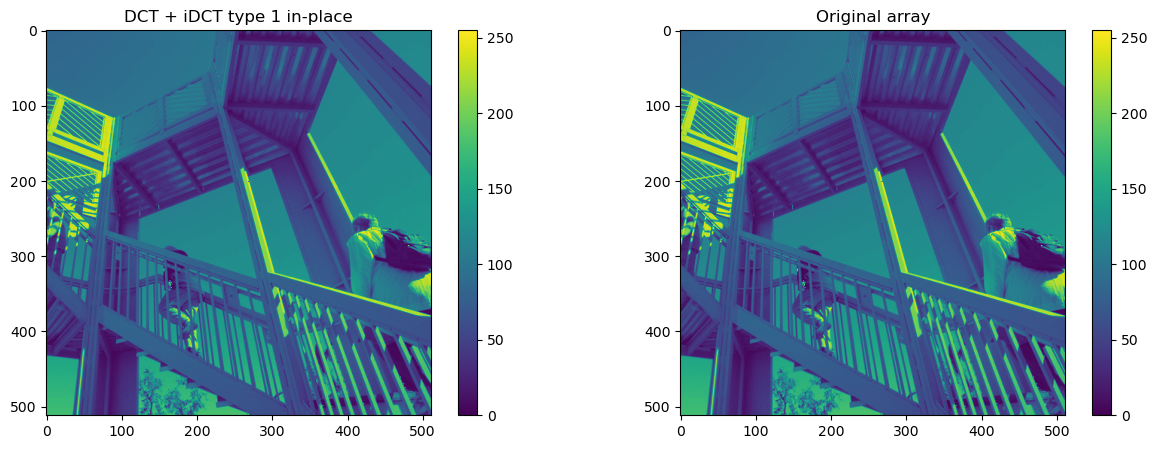

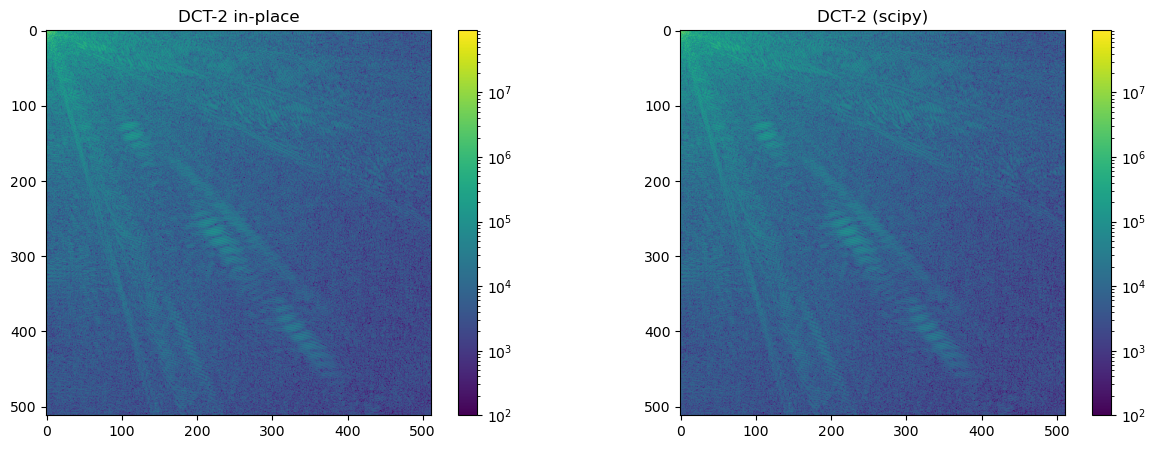

In [ ]:
# single precision, DCT inplace
for dct_type in (1,2,3,4):
    print("Testing DCT type %d" % dct_type)
    d0 = cla.to_device(cq, ascent().astype(np.float32))

    # dct type  (default if dct=True)
    app = VkFFTApp(d0.shape, d0.dtype, queue=cq, ndim=2, dct=dct_type, inplace=True)

    print((abs(d0.get()) ** 2).sum())
    d0 = app.fft(d0, d0)
    print((abs(d0.get()) ** 2).sum())

    dn = dctn(ascent().astype(np.float32), type=dct_type)
    print(np.allclose(d0.get(), dn, rtol=1e-6, atol=dn.max() * 1e-6))

    fig = plt.figure(figsize=(15,5), dpi=100)
    plt.subplot(121)
    plt.imshow(abs(d0.get()), norm=LogNorm(vmin=100))
    plt.colorbar()
    plt.title("DCT-%d in-place" % dct_type)
    plt.subplot(122)
    plt.imshow(abs(dn), norm=LogNorm(vmin=100))
    plt.colorbar()
    plt.title("DCT-%d (scipy)" % dct_type)

    # inverse transform:
    d0 = app.ifft(d0, d0)
    idn = idctn(dn, type=dct_type)
    print((abs(d0.get()) ** 2).sum(), (abs(idn) ** 2).sum())

    print(np.allclose(d0.get(), idn, rtol=1e-4, atol = 1e-3),
          np.allclose(d0.get(), ascent(), rtol=1e-4, atol = 1e-3))

    fig = plt.figure(figsize=(15,5), dpi=100)
    plt.subplot(121)
    plt.imshow(d0.get())
    plt.colorbar()
    plt.title("DCT + iDCT type %d in-place" % dct_type)
    plt.subplot(122)
    plt.imshow(ascent())
    plt.colorbar()
    plt.title("Original array")
    print()

## Complex<->Complex, inplace, F-ordering

In [ ]:

d0 = np.asarray(ascent().astype(np.complex64), order='F')
for axes in [None, (-1,), (-2,)]:
    d = cla.to_device(cq, d0)
    app = VkFFTApp(d.shape, d.dtype, cq, strides=d.strides, axes=axes)

    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(np.fft.fftshift(abs(np.fft.fftn(d0, axes=axes))), norm=LogNorm())
    plt.colorbar()

    d = app.fft(d)

    plt.subplot(122)
    plt.imshow(np.fft.fftshift(abs(d.get())), norm=LogNorm())
    plt.colorbar()

    d = app.ifft(d)


## Complex<->Complex, out-of-place, F-ordering

In [ ]:
d0 = np.asarray(ascent().astype(np.complex64), order='F')
axes = (-1,)
d1 = cla.to_device(cq, d0)
d2 = cla.empty_like(d1)
app = VkFFTApp(d1.shape, d1.dtype, cq, strides=d1.strides, axes=axes, inplace=False)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(np.fft.fftshift(abs(np.fft.fftn(d0, axes=axes))), norm=LogNorm())
plt.colorbar()

print((abs(d.get()) ** 2).sum())
d2 = app.fft(d1, d2)

plt.subplot(122)
plt.imshow(np.fft.fftshift(abs(d2.get())), norm=LogNorm())
plt.colorbar()

d1 = app.ifft(d2, d1)


## Complex<->Complex, inplace, F-ordering, simple FFT interface

In [ ]:
order = 'F'
for axes in [None, (-1,), (-2,)]:
    d0 = np.asarray(ascent().astype(np.complex64), order=order)
    d = cla.to_device(cq, d0)

    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    dn = np.fft.fftshift(abs(np.fft.fftn(d0, axes=axes)))
    plt.imshow(dn, norm=LogNorm())
    plt.colorbar()

    d = vkfftn(d, d, axes=axes)

    plt.subplot(122)
    plt.imshow(np.fft.fftshift(abs(d.get())), norm=LogNorm())
    plt.colorbar()

    d = vkifftn(d, d, axes=axes)
    
    # Test accuracy on random array
    shape, dtype = d0.shape, d0.dtype
    d0 = (np.random.uniform(-0.5, 0.5, shape) + 1j * np.random.uniform(-0.5, 0.5, shape)).astype(dtype)
    d0 = np.asarray(d0, order=order)
    
    d = cla.to_device(cq, d0)
    d = vkfftn(d, d, axes=axes)
    dn = np.fft.fftn(d0, axes=axes)
    print(l2(dn, d.get()), li(dn, d.get()))
    
    d = cla.to_device(cq, d0)
    d = vkifftn(d, d, axes=axes)
    dn = np.fft.ifftn(d0, axes=axes)
    print(l2(dn, d.get()), li(dn, d.get()))
    print()



## Real<->Complex (half-Hermitian) inplace transform, F-ordered, simple fft interface

In [ ]:
# single precision, R2C inplace, # F order
order = 'F'
d0 = np.zeros((514, 512), dtype=np.float32)
d0[:512] = ascent()
d0 = np.asarray(d0, order=order)

d = cla.to_device(cq, d0)

d = vkrfftn(d, d)

dn = rfftn(d0[:-2], axes=(-1,-2))  # Need to force the Hermitian axis as the fast one
print(dn.shape)
print(np.allclose(d.get(), dn, rtol=1e-6, atol=dn.max() * 1e-6))

plt.figure(figsize=(15,5), dpi=100)
plt.subplot(121)
plt.imshow(fftshift(abs(d.get()), axes=0), norm=LogNorm(vmin=100))
plt.colorbar()
plt.title("R->C")
plt.subplot(122)
plt.imshow(fftshift(abs(dn), axes=0), norm=LogNorm(vmin=100))
plt.colorbar()
plt.title("R->C (numpy)")

d = vkirfftn(d, d)
print(np.allclose(d.get()[:-2], d0[:-2], rtol=1e-6, atol = 255e-6))


## Real<->Complex (half-Hermitian) out-of-place, F-ordered, simple fft interface

In [ ]:
# single precision, R2C inplace, # F order
order = 'F'
d0 = ascent().astype(np.float32)
d0 = np.asarray(d0, order=order)

d = cla.to_device(cq, d0)

d = vkrfftn(d)

dn = rfftn(d0, axes=(-1,-2))  # Need to force the Hermitian axis as the fast one
print(dn.shape, d.shape)
print(np.allclose(d.get(), dn, rtol=1e-6, atol=dn.max() * 1e-6))

plt.figure(figsize=(15,5), dpi=100)
plt.subplot(121)
plt.imshow(fftshift(abs(d.get()), axes=0), norm=LogNorm(vmin=100))
plt.colorbar()
plt.title("R->C")
plt.subplot(122)
plt.imshow(fftshift(abs(dn), axes=0), norm=LogNorm(vmin=100))
plt.colorbar()
plt.title("R->C (numpy)")

d = vkirfftn(d)
print(np.allclose(d.get(), d0, rtol=1e-6, atol = 255e-6))
